In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from scipy.stats import beta,norm,zscore,entropy
import matplotlib.patches as patches
import matplotlib.colors as colors
import seaborn as sns
%matplotlib inline

# introduction to analysis of cost/value

Weather forecasts are considered to have “value” when they result in beneficial decision-making by users (Murphy 1993). Several studies have shown that the value of a forecast can be estimated using a simple 2x2 decision problem, where value is expressed in terms of the benefit/utility of taking preventative action relative to the losses endured when adverse weather events occur. In this notebook, we explore ways of measuring and visualizing the performance of weather forecasts by evaluating the relative costs of misclassification errors (“false alarms” and “missed events”). Estimating the value of forecasts for rare hazardous events is a significant challenge, given the catastrophic damages that can result from these events along with minuscule event frequencies (base rates).

## 2x2 contingency table

Forecasts for a well-defined observed event can be evaluated by analyzing the elements of a 2x2 contingency table. A generic form of the 2x2 contingency table is shown below. The observed value for the $i^{th}$ case can be denoted as $x_i = 1$ (or $obs=yes$) when the event was observed to occur,  $x_i = 0$ (or $obs=no$) when the event did not occur (following the notation of Murphy 1988). Forecasts could be provided in one of several forms: continuous (e.g., probabilistic), ordinal (e.g., slight/moderate/high), or binary (yes/no). Continuous and ordinal forecast values can be converted to binary forecasts via thresholding, $f_i = 1$ (or $fcst=yes$) when the forecast value is greater than or equal to a threshold,  $f_i = 0$ (or $fcst=no$) otherwise. The elements of the contingency table are simply the relative frequencies or proportions of each contingency (joint probabilities).

The “a” element of the contingency table provides the proportion of correct “yes” forecasts, often referred to as “true positives” or “hits”. The “b” element provides the proportion of incorrect “yes” forecasts, also known as “false positives” or “false alarms”. The “c” element provides the proportion of incorrect “no” forecasts, also denoted as “false negatives” or “missed events”. The “d” element provides the proportion of correct “no” forecasts, also called “true negatives” or “correct nulls”.

In [2]:
# generic 2x2 contingency table
pd.DataFrame(data=np.array([['a','b','a+b'],['c','d','c+d'],['a+c','b+d','1']]),index=['fcst=yes','fcst=no','col sum'],columns=['obs=yes','obs=no','row sum'])

,obs=yes,obs=no,row sum
fcst=yes,a,b,a+b
fcst=no,c,d,c+d
col sum,a+c,b+d,1


## 2x2 contingency table in ROC space

We can use the definitions of $POD=\frac{a}{a+c},POFD=\frac{b}{b+d},$ and $\bar x = a+c$ to express the elements of the 2x2 contingency table in terms of $POD$, $POFD$, and $\bar x$, this will come in handy later:

In [3]:
# generic 2x2 contingency table in terms of POD, POFD, and base rate
pd.DataFrame(data=np.array([[r'$\bar x (POD)$',r'$(1-\bar x)POFD$',r'$\bar x (POD)+(1-\bar x)POFD$'],[r'$\bar x (1-POD)$',r'$(1-\bar x)(1-POFD)$',r'$1-\bar x (POD)-(1-\bar x)POFD$'],[r'$\bar x$',r'$1-\bar x$','1']]),index=['fcst=yes','fcst=no','col sum'],columns=['obs=yes','obs=no','row sum'])

,obs=yes,obs=no,row sum
fcst=yes,$\bar x (POD)$,$(1-\bar x)POFD$,$\bar x (POD)+(1-\bar x)POFD$
fcst=no,$\bar x (1-POD)$,$(1-\bar x)(1-POFD)$,$1-\bar x (POD)-(1-\bar x)POFD$
col sum,$\bar x$,$1-\bar x$,1


## cost matrix - general score

For a specific decision-maker, we can consider the "costs" (reduction in benefit) or "utility" (additional benefit) of the binary decision of taking protective action (or not) in anticipation of a hazardous event. In this case, another 2x2 table is created which we will call the "cost matrix". The $C_a$ element is the cost incurred when protective action is taken and the event occurs, while the $C_b$ element is the cost incurred when protective action is taken and the event does not occur. (these could be equal to each other if the protective action is "perfect") The $C_d$ element is the cost incurred when no protective action is taken and the event does not occur (often assumed to be zero) while the $C_c$ element is the cost incurred when protective action is not taken and the event occurs, typically assumed to be the largest cost of the four contingencies.

In [4]:
# generic 2x2 cost matrix
pd.DataFrame(data=np.array([[r'$C_a$',r'$C_b$'],[r'$C_c$',r'$C_d$']]),index=['action','no action'],columns=['event','no event'])

,event,no event
action,$C_a$,$C_b$
no action,$C_c$,$C_d$


Thompson (1952) and Murphy (1977) assumed that “the cost of taking protective measures” was $C_a=C_b=C$ , the loss resulting from not taking protective action when hazardous weather occurred was $C_c=L$ , and no costs were incurred when the weather event did not occur and no protective action was taken ($C_d=0$). Richardson (2000) allowed for “preventable loss” ($C_a=C+L-L_1, C_b=C, C_c=L, C_d=0$) which is additional loss beyond the cost of taking protective action when the weather event also occurred. Wandishin and Brooks (2002) considered “utility” instead of cost, allowing for analysis of various reductions in utility occurring in the contingencies when the weather event was either predicted or observed to occur.

Assuming the decision-maker takes action when the forecast system indicates "yes", by taking the sum of the element-by-element product of the 2x2 contingency table with the cost matrix, we can derive a measure representing the overall “full cost” of using a forecast system for decision-making, lower cost is “better”. 

\begin{equation}
costfull = C_a a + C_b b + C_c c + C_d d
\end{equation}

## classic cost-loss ratio approach

Thompson (1952) and Murphy (1977) assumed that “the cost of taking protective measures” was $C_a=C_b=C$ , the loss resulting from not taking protective action when hazardous weather occurred was $C_c=L$ , and no costs were incurred when the weather event did not occur and no protective action was taken ($C_d=0$). Murphy (1977) defined “expense” as the expense per unit loss per forecast. 

The "cost-loss ratio" is simply the ratio of the cost of taking protection action to the loss resulting from not taking protective action when the event occurred:
\begin{equation}
cost/loss = \frac{C}{L}
\end{equation}

Plugging these into the equations above:

\begin{equation}
expense = \frac{costfull}{L} = (\frac{C}{L}-1)\bar x(POD)+\frac{C}{L}(1-\bar x)POFD + \bar x
\end{equation}

Analysis of $expense$ for a given forecast system ($POD,POFD$) and base rate across the full range of decision-makers is typically performed by plotting $expense(\frac{C}{L})$ vs $\frac{C}{L}$

## references/baselines

The expense/cost of a forecast system is typically compared to a couple of "reference" conditions; the costs associated with always taking protective action, costs associated with never taking protective action, and perfect decision-making. Using the Murphy (1977) definition of expense:

### perfect

For a perfect forecast system, $POD=1$ and $POFD=0$, therefore:

$expense_{perfect} = \frac{C}{L}\bar x$


### always protect

For a user who always takes protective action, this is equivalent to a constant "yes" forecast, $POD=1$ and $POFD=1$, therefore:

$expense_{always} = \frac{C}{L}$


### never protect

For a user who never takes protective action, this is equivalent to a constant "no" forecast, $POD=0$ and $POFD=0$, therefore:

$expense_{never} = \bar x$


### reference expense

We assume the decision-maker is aware of their cost/loss situation as well as the base rate (event frequency), and will choose the least-costly "default" decision when no forecast information is available. This will depend on $\frac{C}{L}$ compared with $\bar x$

if $\frac{C}{L}\le\bar x$;
$expense_{ref} = \frac{C}{L}$

if $\frac{C}{L}\gt\bar x$;
$expense_{ref} = \bar x$

## example

We'll use a simple model of the discrimination ability of a forecast system, following Brooks (2004) and originating with classic work by Thurstone (1927). The conditional distributions of the forecast (given "yes" and "no" observations) follow a normal distribution with equal variances, with a separation between them measured in terms of the number of standard deviations between them (we will call this separation distance $d'$). In this example, $d'=1.2$

Text(0.5, 1.0, "standard normal separated by d'=1.2")

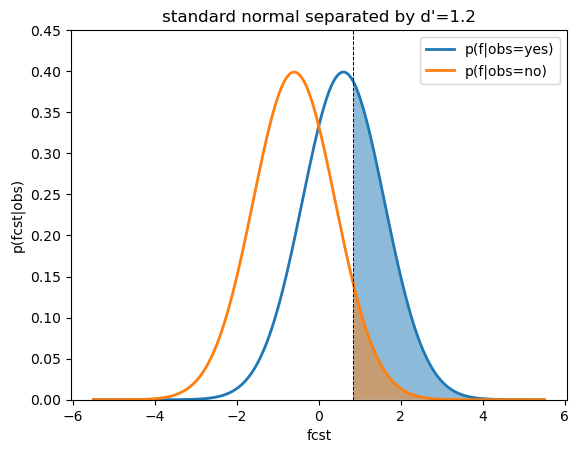

In [5]:
# plot a discrimination diagram for standard normal distribution conditional forecast distributions separated by dprime1
fig,ax = plt.subplots()
dprime1=1.2
x1=np.linspace(-5.5,5.5,1001)
p1=norm.pdf(x1,loc=0.5*dprime1,scale=1.)
p0=norm.pdf(x1,loc=-0.5*dprime1,scale=1.)
ax.plot(x1,p1,label='p(f|obs=yes)',lw=2.)
ax.plot(x1,p0,label='p(f|obs=no)',lw=2.)
ax.plot([x1[577],x1[577]],[0,0.45],'k--',lw=0.7)
ax.fill_between(x1[577:],p1[577:],alpha=0.5)
ax.fill_between(x1[577:],p0[577:],alpha=0.5)
ax.legend()
ax.set_xlabel('fcst')
ax.set_ylabel('p(fcst|obs)')
ax.set_ylim(0.,0.45)
ax.set_title(f"standard normal separated by d'={dprime1}")

## example ROC curve

We can choose a specific forecast decision threshold and compute the elements of the resulting 2x2 contingency table associated with that threshold. The area under the $p(f|obs=yes)$ curve to the right of the threshold is equal to $POD=\frac{a}{a+c}$ and area under the $p(f|obs=no)$ curve to the right of the threshold is equal to $POFD=\frac{b}{b+d}$. A ROC curve is produced by systematically varying this threshold and plotting $POD$ vs $POFD$. This will show the typical connection between POD and POFD, for high forecast thresholds POD and POFD (the areas to the right of the threshold) will both be small, indicating a relatively low proportion of "hits" as well as "false alarms". Low forecast thresholds (shift the threshold to the left on the discrimination diagram) will result in relatively high POD and POFD, with a large fraction of the observed events resulting in "hits" along with a relatively high fraction of the yes forecasts resulting in false alarms. POD and POFD tend move "in tandem". The shapes and relative positions of the conditional forecast distributions controls the shape of the $POD$ vs $POFD$ curve, larger separation between these is considered better "discrimination" between observed events and non-events. The example ROC curve for $d'=1.2$ follows ($POD=0.4$ and $POFD=0.07$ for the threshold shown above):

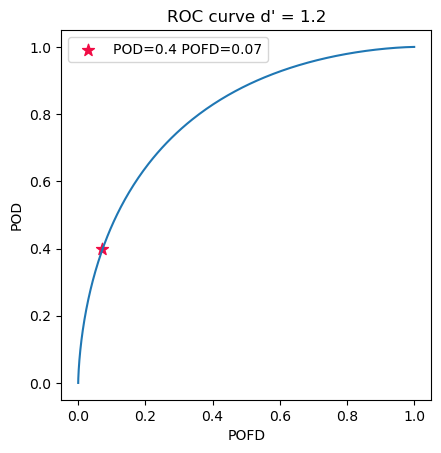

In [6]:
# example ROC curve

fig,ax = plt.subplots()
dprime1=1.2

pod1=norm.cdf(np.linspace(-5.5,5.5,1001),loc=-0.5*dprime1,scale=1.)
pofd1=norm.cdf(np.linspace(-5.5,5.5,1001),loc=0.5*dprime1,scale=1.)
pod_pt=np.round(pod1[np.argmax(pod1>0.4)],2)
pofd_pt=np.round(pofd1[np.argmax(pod1>0.4)],2)
lab1=f'POD={pod_pt} POFD={pofd_pt}'

ax.scatter(pofd_pt,pod_pt,marker='*',s=80,color='#f10c45',label=lab1)
ax.plot(pofd1,pod1)
ax.set_xlabel('POFD')
ax.set_ylabel('POD')
ax.set_title(f"ROC curve d' = {dprime1}")
ax.set_aspect('equal')
ax.legend()

## example Murphy expense curve

For this example we pick an arbitrary decision threshold along this curve that results in $POD=0.4$, $POFD=0.07$, and assuming the base rate is $\bar x=0.1$, the Murphy (1977) expense curve is a plot of $expense$ vs $\frac{C}{L}$, example found below:

$expense = (\frac{C}{L}-1)\bar x(POD)+\frac{C}{L}(1-\bar x)POFD + \bar x$

For a specific $POD, POD,$ and $\bar x$ the expense curve is a straight line in $expense$ space.

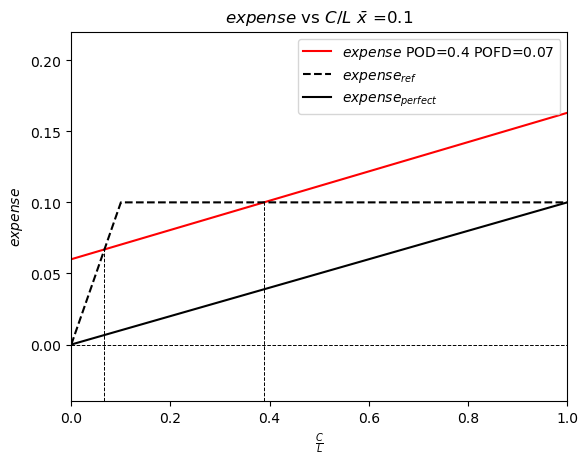

In [7]:
#example Murphy expense curve

xbar1=0.1
pod1=0.4
pofd1=0.07

# calculate locations of curve intersections
aa1=pod1*xbar1
bb1=(1.-xbar1)*pofd1
cc1=(1.-pod1)*xbar1
dd1=(1.-xbar1)*(1.-pofd1)
cl_low=cc1/(cc1+dd1)
cl_hi=aa1/(aa1+bb1)
exp_low=xbar1*(1.-pod1)+cl_low*(xbar1*pod1+(1.-xbar1)*pofd1)
exp_hi=xbar1*(1.-pod1)+cl_hi*(xbar1*pod1+(1.-xbar1)*pofd1)

cost_loss=np.linspace(0.0,1.,101)
expense=np.zeros_like(cost_loss)
expense_clim=np.zeros_like(cost_loss)
expense_perf=np.zeros_like(cost_loss)

expense=xbar1*(1.-pod1)+cost_loss*(xbar1*pod1+(1.-xbar1)*pofd1)
expense_clim[cost_loss<xbar1]=cost_loss[cost_loss<xbar1]
expense_clim[cost_loss>=xbar1]=xbar1
expense_perf=cost_loss*xbar1

plt.plot(cost_loss,expense,color='xkcd:fire engine red',label=r'$expense$'+f' POD={np.round(pod1,2)} POFD={np.round(pofd1,2)}')
plt.plot(cost_loss,expense_clim,'k--',label=r'$expense_{ref}$')
plt.plot(cost_loss,expense_perf,'k',label=r'$expense_{perfect}$')

plt.plot([0.,1.],[0.,0.],'k--',lw=0.7)
plt.plot([cl_low,cl_low],[-0.04,exp_low],'k--',lw=0.7)
plt.plot([cl_hi,cl_hi],[-0.04,exp_hi],'k--',lw=0.7)
plt.xlim(0.,1.0)
plt.ylim(-0.04,.22)

plt.title(r'$expense$ vs $C/L$ $\bar x$ ='+f'{xbar1}')
plt.xlabel(r'$\frac{C}{L}$')
plt.ylabel(r'$expense$')
plt.legend()


## points where expense curve intersects the reference curve

In this example we see that the forecast system will result in $expense$ less than the "default" reference forecast for users in the range of $\frac{C}{L}$ between roughly 0.07 and 0.38. Wandinshin and Brooks (2002) showed that the lower bound of $\frac{C}{L}$ where the forecast is less costly (intersection point of $expense$ and $expense_{ref}$ curves) is equal to the "miss ratio" ($MR=\frac{c}{c+d}$) and the upper bound is equal to the "success ratio" ($SR=\frac{a}{a+b}$). 

These intersection points can also be derived by substituting the definitions of $a$ and $b$ from the 2x2 contingency table in ROC space:

$a=\bar x(POD)$

$b=(1-\bar x)POFD$

$\bar x = a+c$

$expense = (\frac{C}{L}-1)a+\frac{C}{L}b + a + c$

upper bound: $expense = expense_{ref} = \bar x$ at $\frac{C}{L}=\frac{a}{a+b}$

lower bound: $expense = expense_{ref} = \frac{C}{L}$ at $\frac{C}{L}=\frac{c}{c+d}$

## who benefits (or does not benefit) from using forecasts

This shows the range of decision-makers that can benefit from using this forecast system. We find that users with $\frac{C}{L}$ near the base rate tend to benefit from using the forecast, and the greatest benefit (largest difference between $expense$ and $expense_{ref}$) is found for users at $\frac{C}{L}=\bar x$. Decision-makers with a very high loss or very low cost of protection (low $\frac{C}{L}$) require highly accurate forecasts in order for their decisions to result in less expenses in comparison to their "default" decision, which is "always protect". For these users, the relatively high losses associated with the hazard makes them more sensitive to "missed event" errors. On the other side of the chart, decision-makers with a relatively high cost of protection (high $\frac{C}{L}$) or low event frequency also require highly accurate forecasts in order for those to be considered beneficial in comparision with their "never protect" default decision. For these users, the relatively high cost of taking protective action makes them more sensitive to "false alarm" errors.

## relative value

While these Murphy (1977) expense curves are fairly easy to produce and interpret, to this point they have not been adopted widely across the community. Instead, a skill score based on $expense$ called "relative value" has been used, which was also presented by Murphy (1977). Relative value is defined as the value of the forecast relative to the value of a perfect forecast, where "value" is the difference between $expense$ and the default reference $expense_{ref}$.

relative value = $V_{rel}$

\begin{equation}
V_{rel}=\frac{expense_{ref}-expense}{expense_{ref}-expense_{perfect}}
\end{equation}

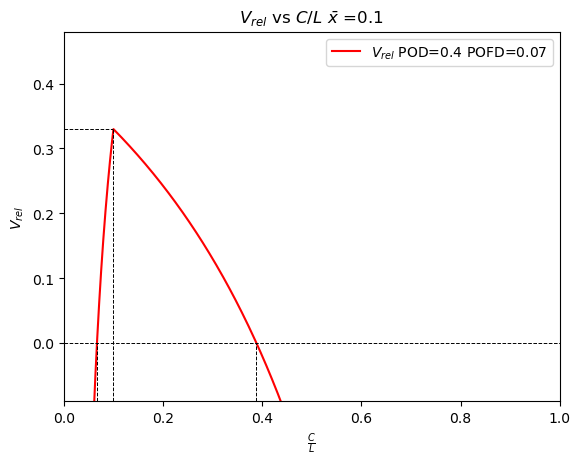

In [8]:
#example relative value curve

xbar1=0.1
pod1=0.4
pofd1=0.07

# calculate locations of zero crossings
aa1=pod1*xbar1
bb1=(1.-xbar1)*pofd1
cc1=(1.-pod1)*xbar1
dd1=(1.-xbar1)*(1.-pofd1)
cl_low=cc1/(cc1+dd1)
cl_hi=aa1/(aa1+bb1)

# use logspace to define cost/loss values and avoid divide by zero errors
cost_loss=np.logspace(-4.0,-0.01,1001)
expense=np.zeros_like(cost_loss)
expense_clim=np.zeros_like(cost_loss)
expense_perf=np.zeros_like(cost_loss)

expense=xbar1*(1.-pod1)+cost_loss*(xbar1*pod1+(1.-xbar1)*pofd1)
expense_clim[cost_loss<xbar1]=cost_loss[cost_loss<xbar1]
expense_clim[cost_loss>=xbar1]=xbar1
expense_perf=cost_loss*xbar1
rel_value=(expense_clim-expense)/(expense_clim-expense_perf)

plt.plot(cost_loss,rel_value,color='xkcd:fire engine red',label=r'$V_{rel}$'+f' POD={np.round(pod1,2)} POFD={np.round(pofd1,2)}')

plt.plot([0.,1.],[0.,0.],'k--',lw=0.7)
plt.plot([0.,xbar1],[pod1-pofd1,pod1-pofd1],'k--',lw=0.7)
plt.plot([xbar1,xbar1],[-0.09,pod1-pofd1],'k--',lw=0.7)
plt.plot([cl_low,cl_low],[-0.09,0.],'k--',lw=0.7)
plt.plot([cl_hi,cl_hi],[-0.09,0.],'k--',lw=0.7)
plt.xlim(0.,1.0)
plt.ylim(-0.09,.48)

plt.title(r'$V_{rel}$ vs $C/L$ $\bar x$ ='+f'{xbar1}')
plt.xlabel(r'$\frac{C}{L}$')
plt.ylabel(r'$V_{rel}$')
plt.legend()


## features of relative value curves

The relative value curve provides similar information as the expense curve, except it is positively oriented (higher score is "better"). $V_{rel}=1$ for a perfect forecast, and we find the same range of decision-makers that can benefit from using the forecast as before (lower bound of $\frac{C}{L}$ is equal to the "miss ratio" ($MR=\frac{c}{c+d}$) and the upper bound is equal to the "success ratio" ($SR=\frac{a}{a+b}$). In addition, the peak relative value is found at $\frac{C}{L}=\bar x$ and Richardson (2000) showed that $V_{rel}=POD-POFD$ (Peirce skill score) at that point. (interesting to note the important role of these conditional probabilities from the 2x2 contingency table) 

Users with $\frac{C}{L}\lt MR$ and $\frac{C}{L}\gt SR$ will not benefit from the forecast and have negative $V_{rel}$. In fact, since the denominator of $V_{rel}$ approaches zero as $\frac{C}{L}$ approaches both zero and one, $V_{rel}$ approaches negative infinity at the low/high $\frac{C}{L}$ ends of the diagram. Since highly negative $V_{rel}$ scores are common, typically only $V_{rel}\ge0$ scores are plotted, but in this example some of the negative values are displayed to illustrate the behavior of this score.

## relative value expression

$V_{rel}$ has been expressed using different notation in previous research (e.g., Murphy 1977; Roebber and Bosart 1996; Richardson 2000; Wandishin and Brooks 2002). Decision-makers can be characterized by $\frac{C}{L}$ or $\alpha$, Wandishin and Brooks (2002) used the differences in utility in the four different contingencies to characterize a user's decision problem. Using the cost matrix notation from before (utility can replace cost here, correct decisions result in higher utility instead of lower costs):

\begin{equation}
\alpha=\frac{(C_b-C_d)}{(C_b-C_d)+(C_c-C_a)}
\end{equation}

The classic "cost-loss" problem (e.g., Thompson (1952); Murphy (1977)) assumes $C_a=C_b=C$, $C_c=L$, $C_d=0$. In this case
$\alpha=\frac{C}{L}$. Richardson (2000) allowed for “preventable loss” $(C_a=C+L-L_1, C_b=C, C_c=L, C_d=0)$ which is additional loss beyond the cost of taking protective action when the weather event also occurred. Following Richardson (2000), $\alpha=\frac{C}{L_1}$

We can also consider the difference in cost (or utility) between correct and incorrect "yes" and "no" forecasts as the costs of misclassification errors. For instance, the cost of a false alarm error is: $FA_1=C_b-C_d$ and the cost of a missed event error is $ME_1=C_c-C_a$. In this case, the "1" subscript is used to indicate that these are the costs of a single event:

\begin{equation}
\alpha=\frac{FA_1}{FA_1+ME_1}
\end{equation}

Going forward, we will use $\alpha$ to characterize decision-makers when analyzing $V_{rel}$

### relative value in terms of $POD$, $POFD$, $\alpha$ and $\bar x$
if $\alpha\le\bar x$;
\begin{equation}
V_{rel} = (1-POFD) - (1-POD)\frac{1-\alpha}{\alpha}\frac{\bar x}{1-\bar x}
\end{equation}

if $\alpha\ge\bar x$;
\begin{equation}
V_{rel} = POD - POFD\frac{\alpha}{1-\alpha}\frac{1-\bar x}{\bar x}
\end{equation}

these expressions are equal when $\alpha=\bar x$;
\begin{equation}
V_{rel} = POD - POFD
\end{equation}

## issues with rare events

The previous examples assumed an event frequency (base rate) of 10%. We might wonder how the relative value chart behaves for very rare events, such as tornados (base rate for tornado reports within 40km of any point over the US is approximately $\bar x$ = 0.001 = 0.1%). The example below uses the same $POD=0.4$ and $POFD=0.07$ as before, with $\bar x=0.001$ instead of $\bar x=0.1$:

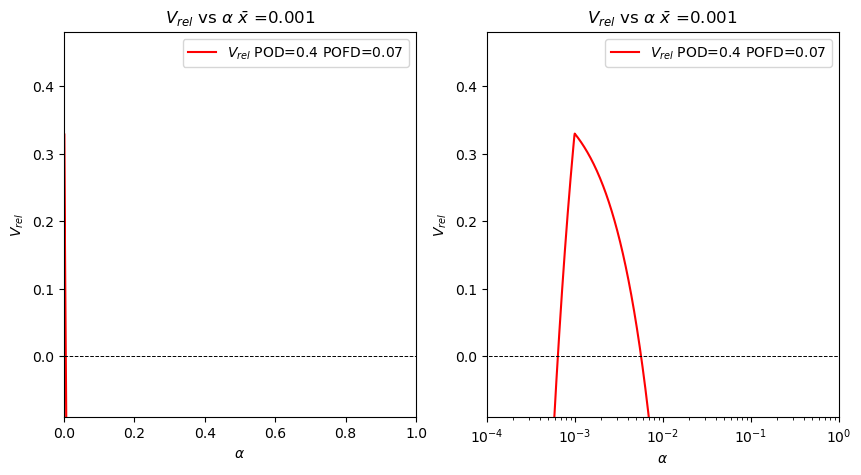

In [9]:
#rare event relative value curve

xbar1=0.001
pod1=0.4
pofd1=0.07

# will use logspace to define alpha values and avoid divide by zero errors
alpha=np.logspace(-4.0,-0.01,1001)
rel_value=np.zeros_like(alpha)
alpha_odds=np.zeros_like(alpha)
xodds=xbar1/(1.-xbar1)
alpha_odds=alpha/(1.-alpha)

rel_value=pod1-pofd1*alpha_odds/xodds
rel_value[alpha<xbar1]=(1.-pofd1)-(1.-pod1)*xodds/alpha_odds[alpha<xbar1]

fig,ax = plt.subplots(1,2,figsize=(10,5))
axs=ax.flat
axs[0].plot(alpha,rel_value,color='xkcd:fire engine red',label=r'$V_{rel}$'+f' POD={np.round(pod1,2)} POFD={np.round(pofd1,2)}')
axs[0].plot([0.,1.],[0.,0.],'k--',lw=0.7)
axs[0].set_xlim(0.,1.0)
axs[0].set_ylim(-0.09,.48)
axs[0].set_title(r'$V_{rel}$ vs $\alpha$ $\bar x$ ='+f'{xbar1}')
axs[0].set_xlabel(r'$\alpha$')
axs[0].set_ylabel(r'$V_{rel}$')
axs[0].legend()

axs[1].semilogx(alpha,rel_value,color='xkcd:fire engine red',label=r'$V_{rel}$'+f' POD={np.round(pod1,2)} POFD={np.round(pofd1,2)}')
axs[1].plot([0.,1.],[0.,0.],'k--',lw=0.7)
axs[1].set_xlim(1.e-4,1.0)
axs[1].set_ylim(-0.09,.48)
axs[1].set_title(r'$V_{rel}$ vs $\alpha$ $\bar x$ ='+f'{xbar1}')
axs[1].set_xlabel(r'$\alpha$')
axs[1].set_ylabel(r'$V_{rel}$')
axs[1].legend()


## rare events

In the rare event situation, there is a tiny "valuable" region in linear $\alpha$ space near $\alpha=0$. This is to be expected, since positive relative value is typically found in the vicinity of $\alpha=\bar x$. If the event occurs very infrequently, the default "never protect" reference decision is less expensive for nearly all except the smallest values of $\alpha$ (very low cost to take protective action relative to losses). This may accurately represent the "value" of forecasts in this simple model decision-making for catastrophic rare hazards such as tornados, and we can display the $V_{rel}$ curve in log($\alpha$) space to improve the visualization of the low-end of the $\alpha$ scale (Richardson (2000) also used a log x-axis in some examples)

However, there is another approach to analyze cost/value that may be helpful for rare events.

## Drummond and Holte (2006) cost curves

The cost of using a forecast system can be expressed in a similar way as in Murphy (1977), following Drummond, C. and Holte, R.C., 2006. Cost curves: An improved method for visualizing classifier performance. Machine learning, 65, 95-130.

Using the same 2x2 contingency table and cost matrix as before, we will subtract the cost of perfect decision-making from the full cost of using the forecast and define this as $cost$

$costfull = C_a a + C_b b + C_c c + C_d d$

$costfull_{perfect} = C_a (a+c) + C_d (b+d)$

$cost=costfull-costfull_{perfect}=b(C_b-C_d)+c(C_c-C_a)$

We previously defined the difference in cost between correct and incorrect "yes" and "no" forecasts as the costs of misclassification errors. The cost of a false alarm error is: $FA_1=C_b-C_d$ and the cost of a missed event error is $ME_1=C_c-C_a$. In this case, the "1" subscript is used to indicate that these are the costs of a single event. Therefore $cost$ is simply:

$cost=b FA_1 + c ME_1$

Substituting the definitions of $b$ and $c$ from the 2x2 contingency table in ROC space:

$b=(1-\bar x)POFD$

$c=\bar x(1-POD)$

$cost=POFD(1-\bar x)FA_1 + (1-POD)\bar x ME_1$

We can define the long-run average costs of missed events and false alarms by multiplying the single event cost by the rates of events occuring/not occuring:

$cost_{FA}=(1-\bar x)FA_1$

$cost_{ME}=\bar x ME_1$

and substitute these into the expression for $cost$:

$cost = POFD cost_{FA} + (1-POD)cost_{ME}$

We can normalize $cost$ by the sum of the long-run average costs of missed events and false alarms, we'll denote this as $cost'$:

\begin{equation}
cost'=cost_{normalized}=\frac{cost}{cost_{FA}+cost_{ME}}=\frac{POFD cost_{FA} + (1-POD)cost_{ME}}{cost_{FA}+cost_{ME}}
\end{equation}

### decision-maker characterization

In this case, we will characterize users by their relative long-run average costs of false alarms. This is similar to the cost-loss and utility ratio approach discussed previously, except in those cases the costs of a single event were used to characterize a decision-maker. In this case, the base rate is included within the variable. We will call this $\alpha'$ (and note that this is the complement of the variable that Drummond and Holte (2006) used $X'=1-\alpha'$)

\begin{equation}
\alpha'=\frac{(1-\bar x)FA_1}{(1-\bar x)FA_1+\bar x ME_1}=\frac{cost_{FA}}{cost_{FA}+cost_{ME}}
\end{equation}

$cost'$ then simplifies to:

\begin{equation}
cost'=(1-POD)(1-\alpha') + POFD\alpha'
\end{equation}

## Drummond and Holte cost curves

Similar to Murphy (1977) expense curves, a cost curve consists of plotting $cost'$ vs $\alpha'$, which is a straight line in this space, connecting $1-POD$ at $\alpha'=0$ with $POFD$ at $\alpha'=1$. A perfect forecast ($POD=1$, $POFD=0$) will have $cost'=0$ for all $\alpha'$. The default reference decisions of "always protect" and "never protect" are also simple straight lines in this space:

### always protect

The "always protect" reference decision is the same as a "all yes" forecast, $POD=1$ and $POFD=1$, therefore:

$cost'_{always}=\alpha'$

### never protect

The "never protect" reference decision is the same as a "all no" forecast, $POD=0$ and $POFD=0$, therefore:

$cost'_{never}=1-\alpha'$

An example cost curve for $POD=0.4$ and $POFD=0.07$ is shown below:

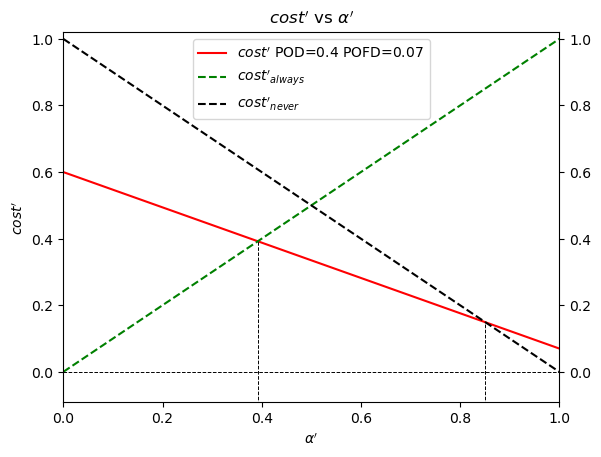

In [10]:
# Drummond and Holte cost curve

pod1=0.4
pofd1=0.07

alpha=np.linspace(0.0,1.,101)
cost=np.zeros_like(alpha)
cost_always=alpha
cost_never=1.-alpha

fig,axs=plt.subplots()
    
lbl=r"$cost'$"+f' POD={np.round(pod1,2)} POFD={np.round(pofd1,2)}'
cost=pofd1*alpha+(1.-pod1)*(1.-alpha)
axs.plot(alpha,cost,color='xkcd:fire engine red',label=lbl)
axs.plot(alpha,cost_always,'g--',label=r"$cost'_{always}$")
axs.plot(alpha,cost_never,'k--',label=r"$cost'_{never}$")
axs.plot([0.,1.],[0.,0.],'k--',lw=0.7)
alpha_low=(1.-pod1)/(2.-pod1-pofd1)
alpha_hi=pod1/(pod1+pofd1)
axs.plot([alpha_low,alpha_low],[-0.1,pofd1*alpha_low+(1.-pod1)*(1.-alpha_low)],'k--',lw=0.7)
axs.plot([alpha_hi,alpha_hi],[-0.1,pofd1*alpha_hi+(1.-pod1)*(1.-alpha_hi)],'k--',lw=0.7)
axs.tick_params(axis='y', which='both', left=True, right=True, labelleft=True,labelright=True)
axs.set_xlim(0.,1.0)
axs.set_ylim(-0.09,1.02)

axs.set_title(r"$cost'$ vs $\alpha'$")
axs.set_xlabel(r"$\alpha'$")
axs.set_ylabel(r"$cost'$")
axs.legend()


## range of decision-makers who can benefit from using forecasts

This shows the range of decision-makers that can benefit from using this forecast system. We find that users with $\alpha'=0.5$ tend to benefit from using the forecast, and the greatest benefit (largest difference between $cost'$ and $cost'_{always}$ or $cost'_{never}$) is found for users at $\alpha'=0.5$. This equates to users with cost-loss ratio equal to the base rate $\frac{C}{L}=\bar x$. Low $\alpha'$ decision-makers (those with a very high long-run missed event cost and/or very low long-run false alarm cost) require forecasts with high POD (1-POD near zero) in order for their decisions to result in lower costs in comparison to their "default" decision, which is "always protect". For these users, the relatively high long-term costs associated with the occurrence of the hazard makes them more sensitive to "missed event" errors. On the other side of the chart, decision-makers with a relatively high cost of protection (high $\alpha'$) require forecasts with low POFD in order for those to be considered beneficial in comparision with their "never protect" default decision. For these users, the relatively high cost of taking protective action makes them more sensitive to "false alarm" errors.

## points where cost curve intersects the reference decision lines

In this example we see that the forecast system will result in $cost'$ less than the "default" reference decision for users in the range of $\alpha'$ between roughly 0.39 and 0.85 (thin dashed lines indicated on the chart). Solving for the intersection points between these lines:

$cost'=(1-POD)(1-\alpha') + POFD\alpha'$

upper bound: 
$cost'=cost'_{never}=1-\alpha'$ 

at $\alpha'_{upper}=\frac{POD}{POD+POFD}$

lower bound: 
$cost'=cost'_{always}=\alpha'$ 

at $\alpha'_{lower}=\frac{1-POD}{1-POD+1-POFD}$

## cost curve for a probabilistic forecast system

The previous example illustrated the cost curve for a single forecast threshold and resulting $POD$, $POFD$ pair. As discussed previously, a continuous (probabilistic) forecast system can be evaluated using a discrimination diagram and ROC curve. By systematically changing the forecast threshold, you will obtain different $POD$ and $POFD$ values, which is represented by a single point in ROC space, but will result in a cost curve line with a different slope. For instance, if we consider the lowest possible forecast threshold, that will produce "all yes" forecasts and $POD=1$, $POFD=1$. This is the green dashed reference line on the cost curve, costs associated with the default "always protect" decision and the $cost'_{always}=\alpha'$ line. As the forecast threshold shifts to higher values, both $POD$ and $POFD$ will be reduced, resulting in a new cost curve with reduced slope compared to the reference $cost'_{always}$ line. Recall that cost curves are straight lines that connect $1-POD$ on the left to $POFD$ on the right, as $POD$ and $POFD$ decrease, the slope of the cost curve associated with that $(POD,POFD)$ pair will also decrease, with the slopes turning negative beyond a certain forecast threshold. Eventually, as the forecast threshold reaches the point where $POD=0$ and $POFD=0$ we will find a cost curve that matches the "never protect" $cost'_{never}=1-\alpha'$ line. 

The chart below shows a series of cost curves associated with different forecast thresholds (thin dashed grey lines), associated with the corresponding ROC curve to the right, for the example discrimation diagram discussed previously $(d'=1.2)$. One can imagine the full ensemble of cost curves generated by plotting the entire series of $(POD,POFD)$ as the forecast threshold changes systematically, and the lower envelope of all of those curves indicating the potential lowest cost for users across the range of $\alpha'$. Users will choose the forecast threshold that results in the lowest cost for their particular decision problem ($\alpha'$). The magenta curve indicates this lower envelope and can be derived by finding the intersection points of two nearby cost lines as you move across the associated ROC curve. The $cost'_{prob}$ and $\alpha'_{prob}$ for this curve are functions of $(POD,POFD)$ and relate to $\frac{\Delta POD}{\Delta POFD}$ (individual cost lines will be tangent to this "probabilistic" curve)

\begin{equation}
\alpha'_{prob}=\frac{POD(1-POD)}{POD(1-POD)+POFD(1-POFD)}
\end{equation}

\begin{equation}
cost'_{prob}=\frac{POFD(1-POD)(1+POD-POFD)}{POD(1-POD)+POFD(1-POFD)}
\end{equation}

Note that Richardson (2000) produced similar "probabilistic" relative value curves by taking the upper envelope of a series of individual $V_{rel}$ curves across different probability thresholds.

(0.0, 1.0)

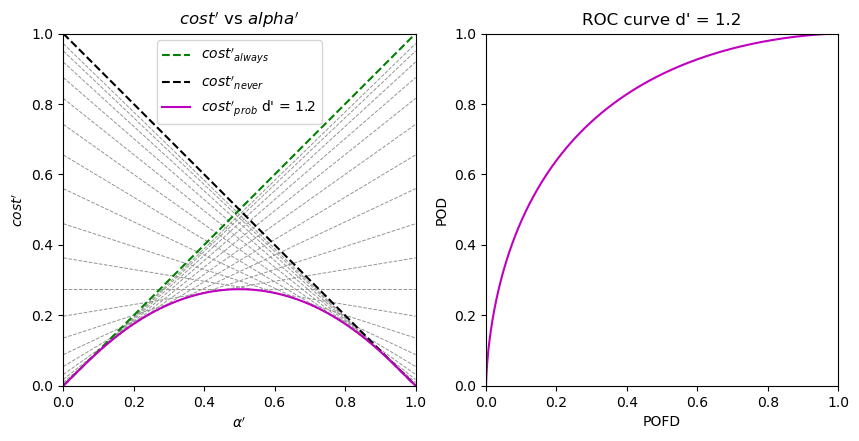

In [11]:
# plot a series of cost curves at different forecast thresholds

dprime1=1.2
alpha=np.linspace(0.0,1.,101)
cost=np.zeros_like(alpha)

fig,axs=plt.subplots(1,2,figsize=(10,5))
    
for zscore in np.linspace(-2.5,2.5,21):
    pod1=norm.cdf(zscore,loc=-0.5*dprime1,scale=1.)
    pofd1=norm.cdf(zscore,loc=0.5*dprime1,scale=1.)
    cost=pofd1*alpha+(1.-pod1)*(1.-alpha)
    axs[0].plot(alpha,cost,color='xkcd:grey',lw=0.7,ls='--')

cost_always=alpha
cost_never=1.-alpha
alphareg=alpha*xbar1/((1.-alpha)*(1.-xbar1)+alpha*xbar1)
axs[0].plot(alpha,cost_always,'g--',label=r"$cost'_{always}$")
axs[0].plot(alpha,cost_never,'k--',label=r"$cost'_{never}$")

# full ROC curve and "probabilistic" cost curve
pod2=norm.cdf(np.linspace(-5.5,5.5,1001),loc=-0.5*dprime1,scale=1.)
pofd2=norm.cdf(np.linspace(-5.5,5.5,1001),loc=0.5*dprime1,scale=1.)
alpha_prob=pod2*(1.-pod2)/(pod2*(1.-pod2)+pofd2*(1.-pofd2))
cost_prob=pofd2*(1.-pod2)*(1.+pod2-pofd2)/(pod2*(1.-pod2)+pofd2*(1.-pofd2))

axs[0].plot(alpha_prob,cost_prob,'m',lw=1.5,label=r"$cost'_{prob}$"+f" d' = {dprime1}")
axs[0].set_title(r"$cost'$ vs $alpha'$")
axs[0].set_xlabel(r"$\alpha'$")
axs[0].set_ylabel(r"$cost'$")
axs[0].set_xlim(0.,1.)
axs[0].set_ylim(0.,1.)
axs[0].set_aspect('equal')
axs[0].legend()

axs[1].plot(pofd2,pod2,'m',lw=1.5)
axs[1].set_xlabel('POFD')
axs[1].set_ylabel('POD')
axs[1].set_title(f"ROC curve d' = {dprime1}")
axs[1].set_aspect('equal')
axs[1].set_xlim(0.,1.)
axs[1].set_ylim(0.,1.)


## impacts of changing forecast/decision thresholds

A series of cost curves shows how users will be affected by changing forecast thresholds (and moving up/down the ROC curve). Higher $(POD,POFD)$ values (associated with low forecast thresholds, high bias) result in cost curves with positive slopes that indicate benefits ($cost'\lt cost'_{always}$) for a wider range of lower $\alpha'\lt 0.5$ users compared to the higher $\alpha'\gt 0.5$ side (where $cost'\lt cost'_{never}$).Lower $(POD,POFD)$ values (associated with high/strict forecast thresholds) result in cost curves with negative slopes that indicate benefit ($cost'\lt cost'_{never}$) for a wider range of higher $\alpha'$ users compared to the lower $\alpha'$ side (where $cost'\lt cost'_{always}$). 

In other words, forecasts with lower $POD,POFD$ benefit users who are more sensitive to false alarms ($\alpha'\gt 0.5$) and higher $POD,POFD$ benefit users who are sensitive to missed events ($\alpha'\lt 0.5$).

## tornado outlook example

Three years (2022-2024) of SPC day 1 tornado probabilistic outlooks (issued 1630 UTC) were verified using a “polygon” approach. A 40 km buffer is added around tornado reports (from the SPC OneTornado database) to define the "observed" polygon, forecast polygons are defined by the outlook geojson files. Areas of “intersection” and "union" between the observed/forecast polygons are calculated to determine the elements of the 2x2 contingency table. The sum of these elements over these three years produces the $POD, POFD$ scores shown below in the summary dataframe, the base rate is approximately $\bar x = 0.0011$:


In [12]:
#tornado outlook example
df_sum = pd.DataFrame(data=np.array([[1.,0.767,0.55,0.251,0.0855,0.00764],[1.,0.0172,0.00506,0.00102,0.000168,0.000007]]).T,index=[0,2,5,10,15,30],columns=['POD','POFD'])
df_sum

,POD,POFD
0,1.00000,1.000000
2,0.76700,0.017200
5,0.55000,0.005060
10,0.25100,0.001020
15,0.08550,0.000168
30,0.00764,0.000007


Text(0.5, 1.0, "$cost'$ vs $alpha'$")

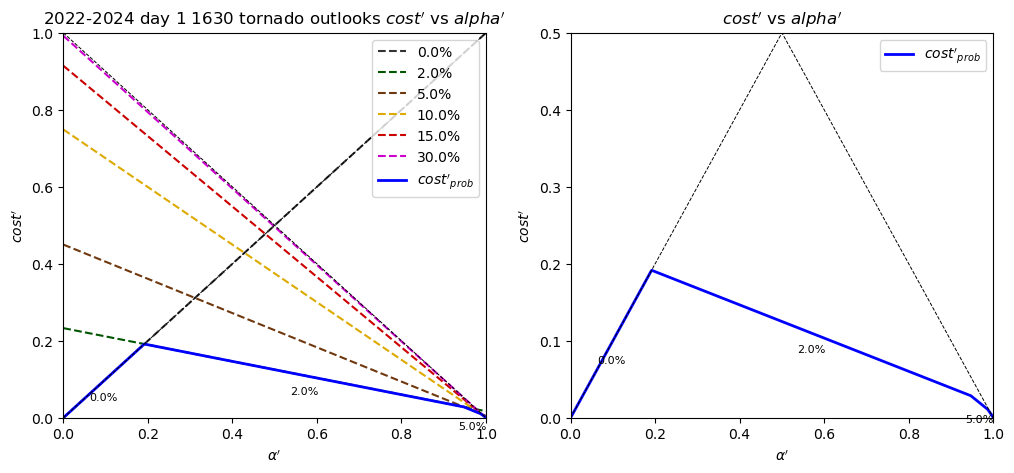

In [13]:
#tornado outlook example cost curve

colorlist=['#333333','#005500', '#70380f', '#DDAA00', '#CC0000', '#CC00CC']

# costs is a 2d array that holds the cost curves for each forecast probability threshold
alpha=np.linspace(0.0,1.,1001).round(3)
costs=np.zeros((len(df_sum.index.unique()),len(alpha)))
df_sum_one=df_sum.reset_index().rename(columns={'index':'LABEL'})
threshs=df_sum_one.LABEL.to_numpy()
for ii in np.arange(len(df_sum_one.LABEL.unique())):
    pod1=df_sum_one.iloc[ii].POD
    pofd1=df_sum_one.iloc[ii].POFD
    costs[ii,:]=(1.-pod1)*(1.-alpha)+pofd1*alpha

#find the minimum cost over all forecast thresholds for each alpha'
min_threshs=threshs[np.argmin(costs,axis=0)]
col_threshs=np.argmin(costs,axis=0)
min_costs=np.min(costs,axis=0)

fig,axs=plt.subplots(1,2,figsize=(12,5))

for ii in np.arange(len(df_sum_one.LABEL.unique())):
    # plot cost line for each forecast threshold
    thr1=df_sum_one.iloc[ii].LABEL
    axs[0].plot(alpha,costs[ii,:],c=colorlist[ii],ls='--',label=f'{thr1}%')
    # label the main segments of the cost curve with corresponding forecast threshold
    alphabar=np.mean(alpha[col_threshs==ii])
    costbar=np.mean(min_costs[col_threshs==ii])
    if ii<3:
        axs[0].text(alphabar,costbar-0.05,f'{thr1}%',ha='center',rotation=0,fontsize=8)
        axs[1].text(alphabar,costbar-0.025,f'{thr1}%',ha='center',rotation=0,fontsize=8)

axs[0].plot(alpha,min_costs,'b',lw=2,label=r"$cost'_{prob}$")
axs[0].plot(alpha,alpha,'k--',lw=0.7)
axs[0].plot(alpha,1.-alpha,'k--',lw=0.7)
axs[0].legend(loc='upper right')
axs[0].set_xlim(0.,1.)
axs[0].set_ylim(0.,1.)
axs[0].set_xlabel(r"$\alpha'$")
axs[0].set_ylabel(r"$cost'$")
axs[0].set_title(r"2022-2024 day 1 1630 tornado outlooks $cost'$ vs $alpha'$")

# duplicate plot but focus on the lower half of cost space
axs[1].plot(alpha,min_costs,'b',lw=2,label=r"$cost'_{prob}$")
axs[1].plot(alpha,np.minimum(alpha,1.-alpha),'k--',lw=0.7)
axs[1].legend(loc='upper right')
axs[1].set_xlim(0.,1.)
axs[1].set_ylim(0.,0.5)
axs[1].set_xlabel(r"$\alpha'$")
axs[1].set_ylabel(r"$cost'$")
axs[1].set_title(r"$cost'$ vs $alpha'$")

## features of cost curve

As expected, the cost line for the 0% forecast threshold is the same as the "always protect" default decision ($POD=POFD=1$, $cost'=\alpha'$). As the 2% threshold, $POD$ drops to 0.77, but $POFD$ falls dramatically to 0.017, $POD$ and $POFD$ continue to fall as the forecast thresholds increase, resulting in the cost lines with increasingly negative slopes. Since the base rate is very small, $POFD$ will tend to remain near zero for a wide range of forecast thresholds, even those with relatively high frequency bias (at 2% threshold $POFD=0.017$, $bias=\frac{a+b}{a+c}\approx 16.5$, $FAR=\frac{b}{a+b}\approx 0.95$) effectively "anchoring" the cost lines in the lower right corner of the diagram. As a result, since the 2% threshold has the highest $POD$, it represents the lowest cost/most valuable threshold for the widest range of decision-makers (except for the very high $\alpha'$ users) as seen in the overall $cost'_{prob}$ curve in blue.

The cost curve is duplicated on the right side, limiting the y-axis to 0.5 since that lower half of the diagram represents the space where "valuable" forecasts $(cost'\lt cost'_{always,never})$ will be displayed.

### comparing discrete forecast thresholds to a fully continuous probabilistic forecast

As discussed previously, individual cost lines will be tangent to a "cost curve" that will show value $(cost'\le cost'_{always or never})$ for all users, if the forecast system has some skill in discriminating events from non-events. For the tornado outlook example, the continuous probabilistic cost curve (shown below) shows the potential for lower costs for a range of lower $\alpha'$ decision-makers, assuming that forecasts with thresholds lower than 2% actually have a similar level of performance as this hypothetical curve (generated by standard normal conditional forecast distributions separated by $d'=2.8$), which we find is approximately tangent to the actual cost curve from the 1630 UTC outlooks for users with $\alpha'\ge 0.8$.

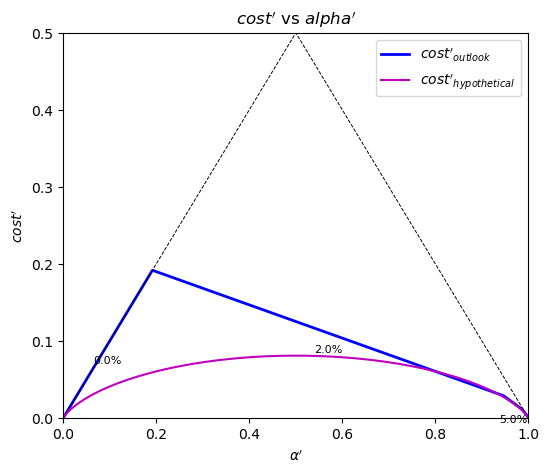

In [14]:
# hypothetical full continuous "probabilistic" cost curve
dprime1=2.8

# costs is a 2d array that holds the cost curves for each forecast probability threshold
alpha=np.linspace(0.0,1.,1001).round(3)
costs=np.zeros((len(df_sum.index.unique()),len(alpha)))
df_sum_one=df_sum.reset_index().rename(columns={'index':'LABEL'})
threshs=df_sum_one.LABEL.to_numpy()
for ii in np.arange(len(df_sum_one.LABEL.unique())):
    pod1=df_sum_one.iloc[ii].POD
    pofd1=df_sum_one.iloc[ii].POFD
    costs[ii,:]=(1.-pod1)*(1.-alpha)+pofd1*alpha

#find the minimum cost over all forecast thresholds for each alpha'
min_threshs=threshs[np.argmin(costs,axis=0)]
col_threshs=np.argmin(costs,axis=0)
min_costs=np.min(costs,axis=0)

fig,ax=plt.subplots(figsize=(6,5))

for ii in np.arange(3):
    # label some segments of the cost curve with corresponding forecast threshold
    thr1=df_sum_one.iloc[ii].LABEL
    alphabar=np.mean(alpha[col_threshs==ii])
    costbar=np.mean(min_costs[col_threshs==ii])
    ax.text(alphabar,costbar-0.025,f'{thr1}%',ha='center',rotation=0,fontsize=8)

ax.plot(alpha,min_costs,'b',lw=2,label=r"$cost'_{outlook}$")
ax.plot(alpha,np.minimum(alpha,1.-alpha),'k--',lw=0.7)

ax.set_xlim(0.,1.)
ax.set_ylim(0.,0.5)
ax.set_xlabel(r"$\alpha'$")
ax.set_ylabel(r"$cost'$")
ax.set_title(r"$cost'$ vs $alpha'$")

# full continuous "probabilistic" cost curve
pod2=norm.cdf(np.linspace(-5.5,5.5,1001),loc=-0.5*dprime1,scale=1.)
pofd2=norm.cdf(np.linspace(-5.5,5.5,1001),loc=0.5*dprime1,scale=1.)
alpha_prob=pod2*(1.-pod2)/(pod2*(1.-pod2)+pofd2*(1.-pofd2))
cost_prob=pofd2*(1.-pod2)*(1.+pod2-pofd2)/(pod2*(1.-pod2)+pofd2*(1.-pofd2))

ax.plot(alpha_prob,cost_prob,'m',lw=1.5,label=r"$cost'_{hypothetical}$")
ax.legend(loc='upper right')

## example of a continuous probabilistic forecast system

Numerican guidance products could be used to generate continuous probabilities. One example of this is the GEFS MLP (machine learning probabilities). For the day 1 tornado product (2022-2024) on these grids, approximately 32% of the forecast values are equal to 0%, and the mean forecast is approximately 0.2%. The non-zero values nearly follow a log-normal distribution (see histogram below) and a large fraction of the values generated are less than 2%. The GEFS MLP day 1 tornado probabilities were verified using a similar "polygon" approach as the SPC day 1 outlooks, converting the GEFS MLP grid to polygons and comparing to 40 km buffers around observed tornado reports. Forecast thresholds were selected at different powers of 10 ($10^{-4}, 10^{-3}, 10^{-2}$) and then similar thresholds as the SPC outlook products. The resulting $POD$ and $POFD$ values are presented in the dataframe below.

![gefsmlp_hist](images/gefs_mlp_histogram.png)

In [15]:
#GEFS MLP tornado outlook example
df_sum_mlp = pd.DataFrame(data=np.array([[1.,0.987,0.964,0.816,0.697,0.445,0.211,0.093,0.032,0.011,0.0016],[1.,0.454,0.236,0.0467,0.0219,0.0063,0.0014,0.0004,0.00012,0.000023,0.000005]]).T,index=[0,0.01,0.1,1,2,5,10,15,20,25,30],columns=['POD','POFD'])
df_sum_mlp

,POD,POFD
0.00,1.0000,1.000000
0.01,0.9870,0.454000
0.10,0.9640,0.236000
1.00,0.8160,0.046700
2.00,0.6970,0.021900
5.00,0.4450,0.006300
10.00,0.2110,0.001400
15.00,0.0930,0.000400
20.00,0.0320,0.000120
25.00,0.0110,0.000023


Text(0.5, 1.0, "$cost'$ vs $alpha'$")

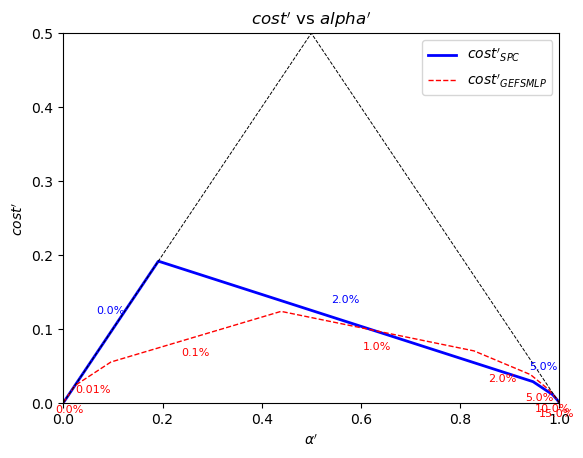

In [16]:
# costs is a 2d array that holds the cost curves for each forecast probability threshold
alpha=np.linspace(0.0,1.,1001).round(3)
costs=np.zeros((len(df_sum.index.unique()),len(alpha)))
df_sum_one=df_sum.reset_index().rename(columns={'index':'LABEL'})
threshs=df_sum_one.LABEL.to_numpy()
for ii in np.arange(len(df_sum_one.LABEL.unique())):
    pod1=df_sum_one.iloc[ii].POD
    pofd1=df_sum_one.iloc[ii].POFD
    costs[ii,:]=(1.-pod1)*(1.-alpha)+pofd1*alpha

#find the minimum cost over all forecast thresholds for each alpha'
min_threshs=threshs[np.argmin(costs,axis=0)]
col_threshs=np.argmin(costs,axis=0)
min_costs=np.min(costs,axis=0)


fig, ax = plt.subplots()
for ii in np.arange(3):
    alphabar=np.mean(alpha[col_threshs==ii])
    costbar=np.mean(min_costs[col_threshs==ii])
    thr1=df_sum_one.iloc[ii].LABEL
    ax.text(alphabar,costbar+0.025,f'{thr1}%',ha='center',color='b',rotation=0,fontsize=8)

ax.plot(alpha,min_costs,'b',lw=2,label=r"$cost'_{SPC}$")

costs_mlp=np.zeros((len(df_sum_mlp.index.unique()),len(alpha)))
df_mlp_one=df_sum_mlp.reset_index().rename(columns={'index':'LABEL'})
threshs_mlp=df_mlp_one.LABEL.to_numpy()
for ii in np.arange(len(df_mlp_one.LABEL.unique())):
    pod11=df_mlp_one.iloc[ii].POD
    pofd11=df_mlp_one.iloc[ii].POFD
    costs_mlp[ii,:]=(1.-pod11)*(1.-alpha)+pofd11*alpha
min_threshs_mlp=threshs_mlp[np.argmin(costs_mlp,axis=0)]
col_threshs_mlp=np.argmin(costs_mlp,axis=0)
min_costs_mlp=np.min(costs_mlp,axis=0)

for ii in np.arange(8):
    alphabar2=np.mean(alpha[col_threshs_mlp==ii])
    costbar2=np.mean(min_costs_mlp[col_threshs_mlp==ii])
    thr1=df_mlp_one.iloc[ii].LABEL
    ax.text(alphabar2,costbar2-0.025,f'{thr1}%',ha='center',color='r',rotation=0,fontsize=8)

ax.plot(alpha,min_costs_mlp,'r--',lw=1,label=r"$cost'_{GEFSMLP}$")
ax.plot(alpha,np.minimum(alpha,1.-alpha),'k--',lw=0.7)
ax.legend(loc='upper right')
ax.set_xlim(0.,1.)
ax.set_ylim(0.,0.5)
ax.set_xlabel(r"$\alpha'$")
ax.set_ylabel(r"$cost'$")
ax.set_title(r"$cost'$ vs $alpha'$")

## GEFS MLP vs SPC day 1 tornado outlooks

We find that the lower GEFS-MLP forecast thresholds (0.01%, 0.1%) provide lower $cost'$ for the low $\alpha'$ users, while the thresholds $\ge 1$% provide similar level of $cost'$ as the SPC outlooks. These results seem to support the idea of providing forecasts with lower thresholds than are currently provided in operational outlooks, although it is difficult to imagine what kinds of users/protective action would be taken at these very low forecast probabilities. 